In [38]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf 
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [39]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

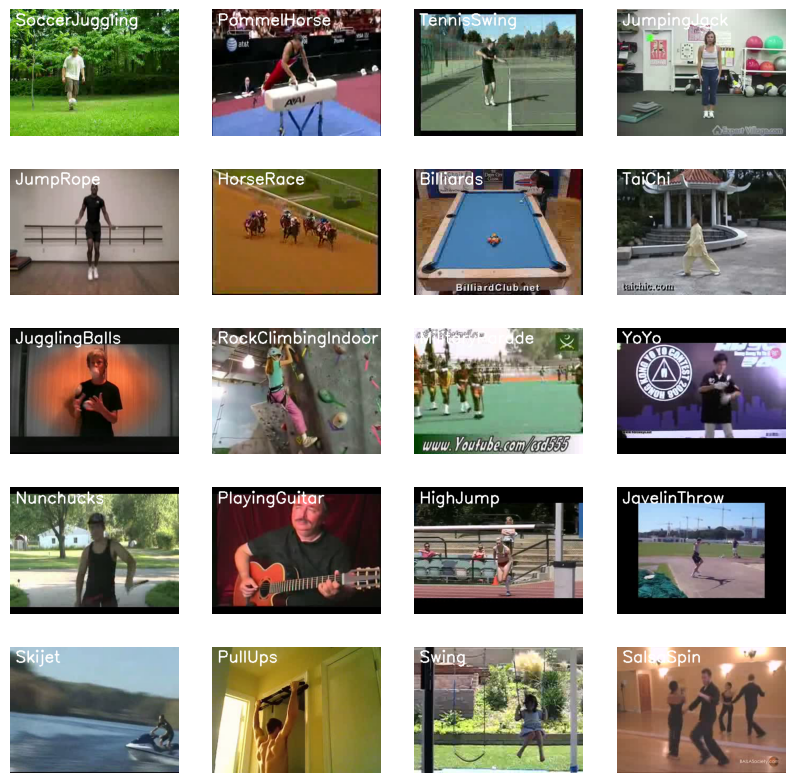

In [40]:
plt.figure(figsize=(10,10))

all_class_name = os.listdir('C:/Users/amite/OneDrive/Desktop/human/UCF50')

random_range = random.sample(range(len(all_class_name)), 20)

for count, index in enumerate(random_range,1):
  selected_class_name = all_class_name[index]
  video_name_list = os.listdir(os.path.join('C:/Users/amite/OneDrive/Desktop/human/UCF50', selected_class_name))
  selected_video_name = random.choice(video_name_list)

  video_reader = cv2.VideoCapture(os.path.join('C:/Users/amite/OneDrive/Desktop/human/UCF50', selected_class_name, selected_video_name))
  _, bgr_frame = video_reader.read()
  video_reader.release()
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
  plt.subplot(5, 4, count);plt.imshow(rgb_frame);plt.axis('off')

In [41]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 20
DATASET_DIR = "C:/Users/amite/OneDrive/Desktop/human/UCF50"
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [42]:
def frameextraction(video_path):
  frame_list = []
  video_reader = cv2.VideoCapture(video_path)
  video_frame_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_interval = max(int(video_frame_count/SEQUENCE_LENGTH),1)

  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_interval)
    success,frame = video_reader.read()
    if not success:
      break
    resized_frame = cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame = resized_frame / 255
    frame_list.append(normalized_frame)
  video_reader.release()
  return frame_list

In [43]:
def create_dataset():
  features = []
  labels = []
  video_file_path = []

  for class_index,class_name in enumerate(CLASSES_LIST):
    print(f'Extracting data of class {class_name}')

    file_list = os.listdir(os.path.join(DATASET_DIR,class_name))

    for file in file_list:
      video_path = os.path.join(DATASET_DIR,class_name,file)
      frames = frameextraction(video_path)

      if len(frames) == SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_file_path.append(video_path)

  features = np.asarray(features)
  labels = np.array(labels)

  return features,labels,video_file_path



In [44]:
features,labels,video_file_path = create_dataset()

Extracting data of class WalkingWithDog
Extracting data of class TaiChi
Extracting data of class Swing
Extracting data of class HorseRace


In [45]:
encode_labels = to_categorical(labels)

In [46]:
feature_train, feature_test, label_train, label_test = train_test_split(features, encode_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [10]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [11]:
convlstm_model = create_convlstm_model()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = feature_train, y = label_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
73/73 [==============================] - 43s 457ms/step - loss: 1.3829 - accuracy: 0.3014 - val_loss: 1.3679 - val_accuracy: 0.3151 - lr: 0.0010
Epoch 2/50
73/73 [==============================] - 32s 439ms/step - loss: 1.3223 - accuracy: 0.4281 - val_loss: 1.2891 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 3/50
73/73 [==============================] - 32s 432ms/step - loss: 1.1930 - accuracy: 0.4932 - val_loss: 1.1994 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 4/50
73/73 [==============================] - 37s 503ms/step - loss: 1.1459 - accuracy: 0.5308 - val_loss: 1.0235 - val_accuracy: 0.6027 - lr: 0.0010
Epoch 5/50
73/73 [==============================] - 33s 449ms/step - loss: 0.9625 - accuracy: 0.5925 - val_loss: 0.8621 - val_accuracy: 0.5753 - lr: 0.0010
Epoch 6/50
73/73 [==============================] - 32s 443ms/step - loss: 0.7353 - accuracy: 0.6884 - val_loss: 0.7179 - val_accuracy: 0.7260 - lr: 0.0010
Epoch 7/50
73/73 [==============================] - 32s 441ms/st

In [13]:
model_eval_history = convlstm_model.evaluate(feature_test, label_test)

4/4 [==============================] - 1s 122ms/step - loss: 0.6056 - accuracy: 0.7951


In [15]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_eval_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save(model_file_name)

In [47]:
import os

def get_class_names(directory_path):
    """
    Get the names of all classes in the given directory.
    Args:
    directory_path: The path to the directory containing class subdirectories.

    Returns:
    class_names: A list of class names.
    """
    # List all subdirectories in the main directory
    class_names = [name for name in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, name))]
    return class_names

# Path to the main directory containing class subdirectories
main_directory_path = "C:/Users/amite/OneDrive/Desktop/human/UCF50"

# Get class names dynamically
CLASS_LIST = get_class_names(main_directory_path)

# Print class names to verify
print("Class names:", CLASS_LIST)


Class names: ['BaseballPitch', 'Basketball', 'BenchPress', 'Biking', 'Billiards', 'BreastStroke', 'CleanAndJerk', 'Diving', 'Drumming', 'Fencing', 'GolfSwing', 'HighJump', 'HorseRace', 'HorseRiding', 'HulaHoop', 'JavelinThrow', 'JugglingBalls', 'JumpingJack', 'JumpRope', 'Kayaking', 'Lunges', 'MilitaryParade', 'Mixing', 'Nunchucks', 'PizzaTossing', 'PlayingGuitar', 'PlayingPiano', 'PlayingTabla', 'PlayingViolin', 'PoleVault', 'PommelHorse', 'PullUps', 'Punch', 'PushUps', 'RockClimbingIndoor', 'RopeClimbing', 'Rowing', 'SalsaSpin', 'SkateBoarding', 'Skiing', 'Skijet', 'SoccerJuggling', 'Swing', 'TaiChi', 'TennisSwing', 'ThrowDiscus', 'TrampolineJumping', 'VolleyballSpiking', 'WalkingWithDog', 'YoYo']


In [51]:
import os
from yt_dlp import YoutubeDL

def download_youtube_videos(url, output_directory, format_id='best'):
    ydl_opts = {
        'outtmpl': os.path.join(output_directory, '%(title)s.%(ext)s'),
        'format': format_id,
        'noplaylist': True,
        'quiet': True,
        'no_warnings': True
    }
    try:
        with YoutubeDL(ydl_opts) as ydl:
            info_dict = ydl.extract_info(url, download=True)
            video_title = info_dict.get('title', None)
            return video_title
    except Exception as e:
        print(f"Error: {e}")
        return None

def list_available_formats(url):
    ydl_opts = {
        'listformats': True,
        'quiet': True
    }
    try:
        with YoutubeDL(ydl_opts) as ydl:
            ydl.extract_info(url, download=False)
    except Exception as e:
        print(f"Error: {e}")

# Creating the output directory if it does not exist
output_directory = 'Youtube_Videos'
os.makedirs(output_directory, exist_ok=True)

# Check available formats
print("Available formats:")
list_available_formats('https://www.youtube.com/watch?v=8u0qjmHIOcE')

# Downloading a YouTube Video with a specific format (e.g., format ID '133')
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', output_directory, format_id='133')

# Check if video_title is not None
if video_title:
    # Getting the YouTube video's path you just downloaded
    input_video_file_path = os.path.join(output_directory, f'{video_title}.mp4')
    print(f'Video downloaded successfully: {input_video_file_path}')
else:
    print('Failed to download video.')

# List the files in the output directory
print(os.listdir(output_directory))


Available formats:


         n = JfJxH9Uk-IO3DEgA ; player = https://www.youtube.com/s/player/0e90208b/player_ias.vflset/en_US/base.js
         n = 8q3NEjAkqFmAdR3o ; player = https://www.youtube.com/s/player/0e90208b/player_ias.vflset/en_US/base.js


ID      EXT   RESOLUTION FPS CH |   FILESIZE  TBR PROTO | VCODEC       VBR ACODEC      ABR ASR MORE INFO
--------------------------------------------------------------------------------------------------------------------
sb2     mhtml 48x27        3    |                 mhtml | images                               storyboard
sb1     mhtml 60x45        1    |                 mhtml | images                               storyboard
sb0     mhtml 120x90       1    |                 mhtml | images                               storyboard
233     mp4   audio only        |                 m3u8  | audio only       unknown             Default
234     mp4   audio only        |                 m3u8  | audio only       unknown             Default
139-drc m4a   audio only      2 |  186.59KiB  49k https | audio only       mp4a.40.5   49k 22k low, DRC, m4a_dash
139     m4a   audio only      2 |  186.59KiB  49k https | audio only       mp4a.40.5   49k 22k low, m4a_dash
140-drc m4a   audio only      2

In [56]:
from tensorflow.keras.models import load_model
convlstm_model = load_model('C:/Users/amite/OneDrive/Desktop/finalhuman\convlstm_model___Date_Time_2024_07_24__15_10_53___Loss_0.6056122779846191___Accuracy_0.7950820326805115.h5')

In [58]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [59]:
# Construct the output video path.
output_video_file_path = f'{output_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Display the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 0s 54ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [30]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform single action recognition prediction on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []
    
    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Read a frame.
        success, frame = video_reader.read() 

        # Check if frame is not read properly then break the loop.
        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255
        
        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASS_LIST[predicted_label]
    
    # Display the predicted action along with the prediction confidence.
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    # Release the VideoCapture object. 
    video_reader.release()